In [9]:
import pandas as pd 
import numpy as np 
import math 
import torch
import torchvision
from torch import nn
from torch.utils.data import DataLoader 
from torchvision import datasets 
from torchvision.transforms import ToTensor 
import matplotlib.pyplot as plt  
import sklearn as sk 
from sklearn.metrics import mean_squared_error, mean_absolute_error 
from statsmodels.tsa.statespace.sarimax import SARIMAX 
from statsmodels.tsa.stattools import adfuller 
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_absolute_error, mean_squared_error
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf 
import pyspark 
from pyspark import SparkContext 
from pyspark.sql import SparkSession 
from pyspark.sql.types import StructField, StructType, StringType, LongType, IntegerType, FloatType 
from pyspark.sql.functions import col, column 
from pyspark.sql.functions import expr 
from pyspark.sql.functions import split 
from pyspark.sql import Row
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_curve, auc

In [10]:
ss=SparkSession.builder.master("local").appName("DS340 Project").getOrCreate()
ss.sparkContext.setCheckpointDir("~/scratch")

In [11]:
staffing_schema = StructType([
    StructField("year", IntegerType(), True),
    StructField("oshpd_id", IntegerType(), True),
    StructField("county_Name", IntegerType(), False),
    StructField("er_service_level_desc", IntegerType(), False),
    StructField("type", IntegerType(), False),
    StructField("count", IntegerType(), True)
])

df_spark = ss.read.csv("EncountersByFacility.csv", header=True, inferSchema=True)
df = df_spark.toPandas()

ts_df = df.groupby("year")["count"].sum().reset_index().sort_values("year")
ts_df["year"] = pd.to_datetime(ts_df["year"], format="%Y")
ts_df.set_index("year", inplace=True)

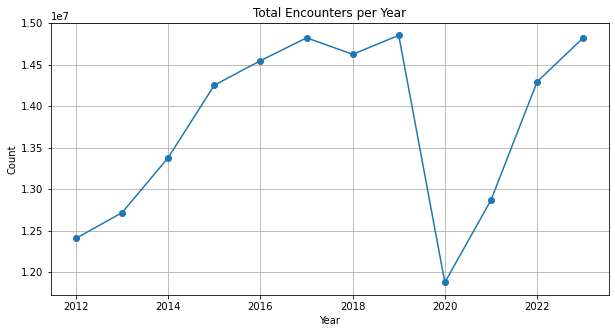

ADF Statistic: -9.6428
p-value: 1.5054e-16


In [12]:
plt.figure(figsize=(10, 5))
plt.plot(ts_df.index.to_numpy(), ts_df["count"].to_numpy(), marker='o')
plt.title("Total Encounters per Year")
plt.xlabel("Year")
plt.ylabel("Count")
plt.grid(True)
plt.show()

adf_result = adfuller(ts_df['count'])
print(f"ADF Statistic: {adf_result[0]:.4f}")
print(f"p-value: {adf_result[1]:.4e}")

In [13]:
ts_df['log_count'] = np.log(ts_df['count'])

model = ARIMA(ts_df['log_count'], order=(1,0,1))
results = model.fit()
print(results.summary())

                               SARIMAX Results                                
Dep. Variable:              log_count   No. Observations:                   12
Model:                 ARIMA(1, 0, 1)   Log Likelihood                  14.991
Date:                Tue, 21 Oct 2025   AIC                            -21.982
Time:                        13:29:59   BIC                            -20.042
Sample:                    01-01-2012   HQIC                           -22.700
                         - 01-01-2023                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         16.4357      0.049    333.993      0.000      16.339      16.532
ar.L1          0.1358      1.019      0.133      0.894      -1.861       2.133
ma.L1          0.3541      1.090      0.325      0.7

/storage/home/rnl5148/.local/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency YS-JAN will be used.
  self._init_dates(dates, freq)
/storage/home/rnl5148/.local/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency YS-JAN will be used.
  self._init_dates(dates, freq)
/storage/home/rnl5148/.local/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency YS-JAN will be used.
  self._init_dates(dates, freq)


/tmp/ipykernel_287932/3637332254.py:10: FutureWarning: 'Y' is deprecated and will be removed in a future version, please use 'YE' instead.
  future_years = pd.date_range(start=last_year, periods=forecast_steps, freq='Y')


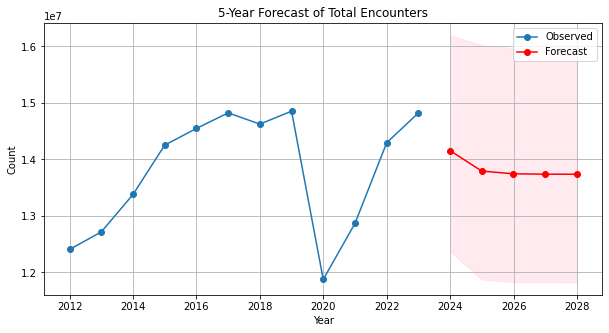

In [14]:
forecast_steps = 5
forecast = results.get_forecast(steps=forecast_steps)
forecast_ci = forecast.conf_int()

forecast_mean = np.exp(forecast.predicted_mean)
forecast_lower = np.exp(forecast_ci.iloc[:,0])
forecast_upper = np.exp(forecast_ci.iloc[:,1])

last_year = ts_df.index.max()
future_years = pd.date_range(start=last_year, periods=forecast_steps, freq='Y')

def to_1d_datetime(idx):
    if isinstance(idx, pd.PeriodIndex):
        return idx.to_timestamp().to_numpy()
    return idx.to_numpy() if hasattr(idx, 'to_numpy') else np.array(idx)

ts_index = ts_df.index.to_numpy()
observed = ts_df['count'].to_numpy()

forecast_index = future_years.to_numpy()
forecast_mean_np = forecast_mean.to_numpy()
forecast_lower_np = forecast_lower.to_numpy()
forecast_upper_np = forecast_upper.to_numpy()

plt.figure(figsize=(10,5))

plt.plot(ts_index, observed, label='Observed', marker='o')

plt.plot(forecast_index, forecast_mean_np, label='Forecast', color='red', marker='o')

plt.fill_between(forecast_index, forecast_lower_np, forecast_upper_np, color='pink', alpha=0.3)

plt.title("5-Year Forecast of Total Encounters")
plt.xlabel("Year")
plt.ylabel("Count")
plt.legend()
plt.grid(True)
plt.show()

In [15]:
pred_in_sample = np.exp(results.fittedvalues)

mae = mean_absolute_error(ts_df['count'], pred_in_sample)
rmse = np.sqrt(mean_squared_error(ts_df['count'], pred_in_sample))

print(f"In-sample MAE: {mae:,.2f}")
print(f"In-sample RMSE: {rmse:,.2f}")

In-sample MAE: 746,938.07
In-sample RMSE: 934,176.74


In [16]:
ss.stop()